# Libraries

In [13]:
import csv
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
from scipy import linalg 
from sklearn.datasets import load_breast_cancer 
import seaborn as sns 

# Loading Data

In [14]:
X,y = load_breast_cancer(return_X_y=True)
ones = np.ones((np.size(X,0),1))
X = np.hstack((ones,X))
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
X_train = X_train.reshape((455,31))
X_test = X_test.reshape((114,31))
Y_train = Y_train.reshape((455,1))
Y_test = Y_test.reshape((114,1))

# Data Analysis

In [15]:
data = pd.read_csv('data.csv')
print(data.head(5))
data = np.array(data)


  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33 

Covariance Matrix between features(mean)

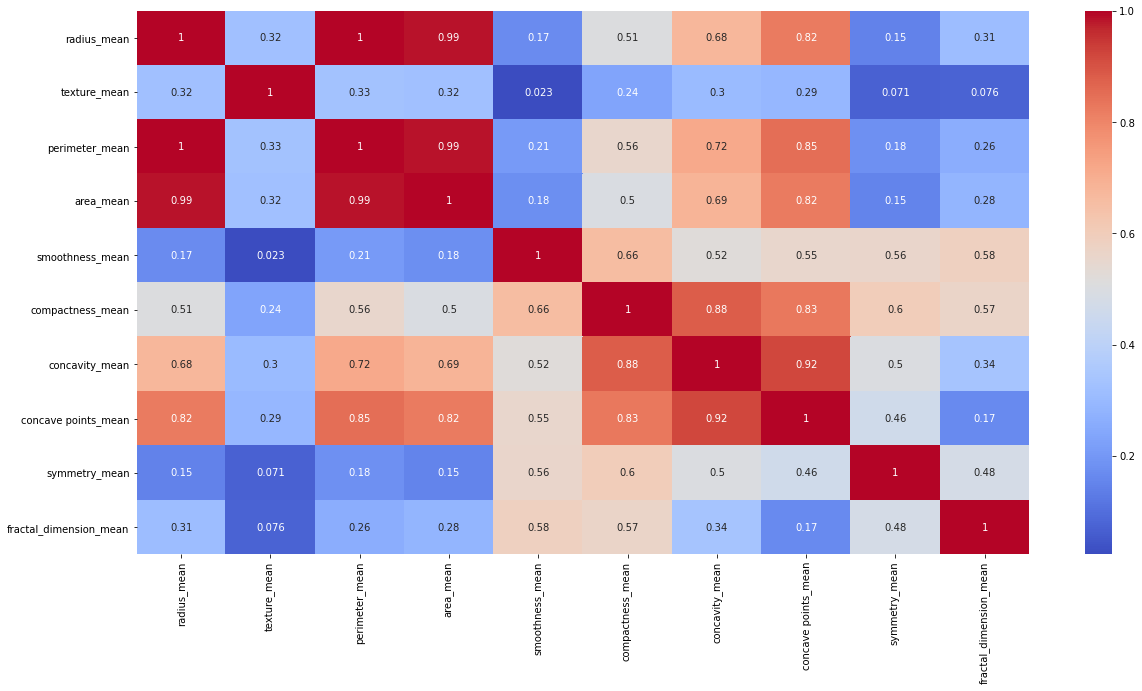

In [16]:
df1 = pd.read_csv('data.csv', usecols = [i for i in range(11)])
plt.figure(figsize=(20, 10))
sns.heatmap(df1.corr().abs(),  cmap="coolwarm", annot=True)
plt.show()

Covariance Matrix between features(se)

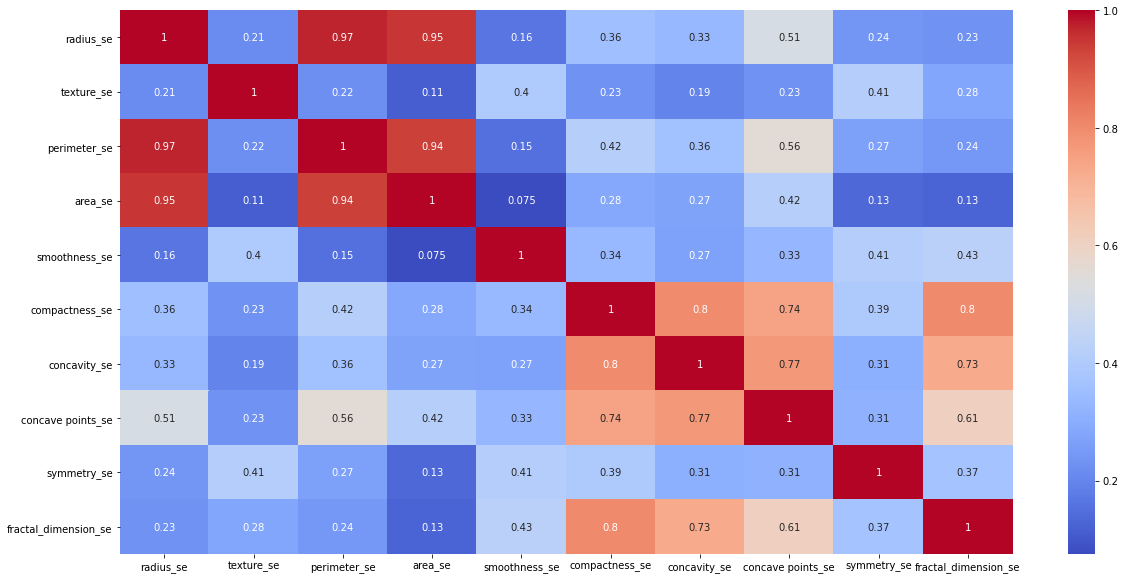

In [17]:
df2 = pd.read_csv('data.csv', usecols = [i for i in range(11,21)])
plt.figure(figsize=(20, 10))
sns.heatmap(df2.corr().abs(),  cmap="coolwarm", annot=True)
plt.show()

Covariance Matrix between features(worst)

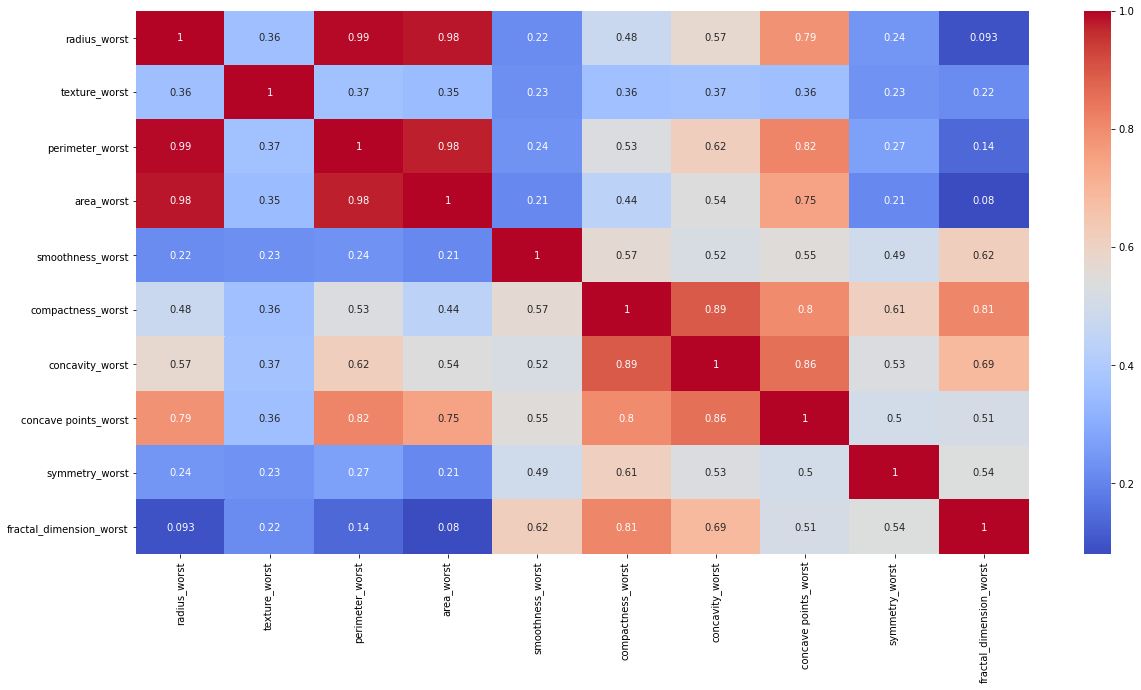

In [18]:
df3 = pd.read_csv('data.csv', usecols = [i for i in range(21,31)])
plt.figure(figsize=(20, 10))
sns.heatmap(df3.corr().abs(),  cmap="coolwarm", annot=True)
plt.show()

Pie Chart showing the proportion of Benign and Malign tumors

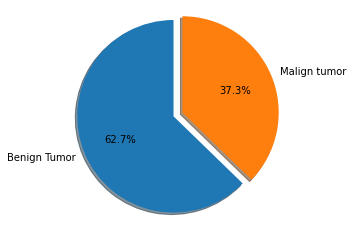

In [19]:
b_counter = 0
m_counter = 0
for i in range(np.size(data,0)):
	if data[i,0] == 'M':
		data[i,0] = 1
		m_counter += 1
	else:
		data[i,0] = 0
		b_counter += 1
size1 = np.round((b_counter/np.size(data,0)) * 100,2)
size2 = 100 - size1
explode = (0, 0.1)
labels = 'Benign Tumor', 'Malign tumor'
sizes = [size1,size2]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels,explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

# Functions

Defining the probability of a pair $({x}_1,{x}_2)$ to be classified as 0 by our function, i.e., $Pr(G = 0|X = x)$.

In [20]:
def probability_k1(row,parameters):
	result = np.exp(row @ parameters)/(1 + np.exp(row @ parameters))
	return result 


Defining the probability vector.

In [21]:
def probability_vector(dataset,parameters):
	p = np.zeros((np.size(dataset,0),1))
	for i in range(np.size(dataset,0)):
		p[i] = probability_k1(dataset[i,:],parameters)
	return p 

Defining the diagonal matrix of weights $W$, that consists of a matrix with: $W(i,i) = Pr(G = 0|X = {x}_i) \times (1 - Pr(G = 0|X = {x}_i))$

In [22]:
def weight_matrix(dataset,parameters):
	w = np.eye((np.size(dataset,0)))
	for i in range(np.size(dataset,0)):
		w[i,i] = probability_k1(dataset[i,:],parameters) * (1 - probability_k1(dataset[i,:],parameters))
	return w 

As an error control, lets define the misclassification rate of the algorithm

In [23]:
def misclassification(x,y,parameters):
	prediction = probability_vector(x,parameters)
	p = np.round(prediction)
	counter = 0
	for i in range(np.size(prediction,0)):
		if np.absolute(p[i] - y[i]) == 0:
			counter = counter 
		else:
			counter += 1
	return counter 


The algorithm updates the parameter beta according to the following:
$B^{new} =(X^T W X)^{-1} X^T W z$, where $z = X B^{old} + W^{-1} (y - p)$

In [24]:
def newton_step(dataset,y,n_iter):
	theta = np.zeros((np.size(dataset,1),1))
	for i in range(n_iter):
		z = dataset @ theta + np.linalg.pinv(weight_matrix(dataset,theta)) @ (y - probability_vector(dataset,theta))
		theta = np.linalg.pinv(dataset.T @ weight_matrix(dataset,theta) @ dataset) @ dataset.T @ weight_matrix(dataset,theta) @ z 
	return theta 

# Results

In [25]:
beta = newton_step(X_train,Y_train,15)
print(f"The number of misclassifications within the training set is: {misclassification(X_train,Y_train,beta)}")
print(f"That gives us an aproximate correct answer rate of: {np.round((np.size(Y_train,0) - misclassification(X_train,Y_train,beta))/np.size(Y_train,0),2) * 100}%")
print(f"The number of misclassifications within the test set is: {misclassification(X_test,Y_test,beta)}")
print(f"That gives us an aproximate correct answer rate of: {np.round((np.size(Y_test,0) - misclassification(X_test,Y_test,beta))/np.size(Y_test,0),2) * 100}% ")


The number of misclassifications within the training set is: 0
That gives us an aproximate correct answer rate of: 100.0%
The number of misclassifications within the test set is: 5
That gives us an aproximate correct answer rate of: 96.0% 


# 5-Fold Cross-Validation

 We first split the training dataset into $k = 5$ parts, and then calculate the prediction error for each $k = 1,2,3,4,5$, using $k-1$ parts as the new training set. This gives us 5 different estimates for the prediction error. After this we combine them and average over the total number of samples $N = 455$ of the dataset, giving us the final CV prediction error.

In [26]:
XT1, XT2, XT3, XT4, XT5 = X_train[:91,:], X_train[91:182,:], X_train[182:273,:], X_train[273:364,:], X_train[364:,:]
YT1, YT2, YT3, YT4, YT5 = Y_train[:91,:], Y_train[91:182,:], Y_train[182:273,:], Y_train[273:364,:], Y_train[364:,:]
X_matrix = np.array((XT1,XT2,XT3,XT4,XT5)) # 3D matrix that indexes the partitioned datasets
Y_matrix = np.array((YT1,YT2,YT3,YT4,YT5))
error_index = np.zeros((5,1))
CV = 0
for j in range(5):
    training_setX = np.zeros((1,31))
    training_setY = np.zeros((1,1))
    for w in range(5):
        if w != j :
            training_setX = np.vstack((training_setX,X_matrix[w,:,:]))
            training_setY = np.vstack((training_setY,Y_matrix[w,:,:]))
        else :
            training_setX = training_setX
            training_setY = training_setY
    training_setX = np.delete(training_setX,0,0)
    training_setY = np.delete(training_setY,0,0)
    predictors = newton_step(training_setX,training_setY,15)
    error_index[j] = misclassification(X_matrix[j,:,:],Y_matrix[j,:,:],predictors)
CV= (sum(error_index))/455  
print(f"The CV error is:{np.round(CV,2)}")

The CV error is:[0.06]
